## Indian Liver Dataset Patients: Classification (4/5)

In [15]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, f1_score, precision_score 
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [16]:
df = pd.read_csv('../input/indian-liver-patients-feature-selection-2-5/liver_reduced_features.csv')

In [17]:
df.head()

,Age,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Albumin_and_Globulin_Ratio,liver_disease
0,65,0.7,187,16,0.90,1
1,62,10.9,699,64,0.74,1
2,62,7.3,490,60,0.89,1
3,58,1.0,182,14,1.00,1
4,72,3.9,195,27,0.40,1


## Scale the data

In [18]:
scaler = StandardScaler()
X = df.iloc[:,:-1].values #features
y = df.iloc[:,-1].values.reshape(583,1) #targer

X_scaled = StandardScaler().fit_transform(X) #scale features

## Classifiers
I implement Logistic Regression, Naive Bayes, kNN and Random Forest classifiers. Due to the imbalance cases on the two classes, it is a challege to find a classifier that manages to correctly classify both negative and positive cases. I use stratified 10 fold cross validation to train the models. Also, I do not use Accuracy as the representative metric to evaluate a classifier, but measures like f1 score, AUC, sensitivity and specificity will be calculated.
1. Sensitivity = $ \frac{TP}{TP+FN} $
2. Specificity = $ \frac{TN}{TN+FP} $
3. Accuracy = $ \frac{TN+TP}{TN+TP+FP+FN}$
4. F1 Score = $ \frac{2TP}{2TP+FP+FN}$

In [19]:
#Cross Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

In [20]:
lr = LogisticRegression(random_state=1)
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(max_depth=10, min_samples_split = 5)
#mlp = MLPClassifier(hidden_layer_sizes=(1,9), activation='logistic', solver='sgd', alpha=1e-5, learning_rate='adaptive', random_state=100, verbose=False)
classifiers = [lr, nb, knn, rf]

In [21]:
d = {}
l = ['Logistic Regression', 'Naive Bayes', 'kNN', 'Random Forest']
i = 0
metrics = pd.DataFrame(columns = ['Accuracy','F1 Score','Sensitivity', 'Specificity', 'AUC']) 
for clf in classifiers:
    clf_accuracy = []
    clf_f1_score = []
    clf_specificity = []
    clf_sensitivity = []
    clf_auc = []
    tprs = []
    mean_fpr = []
    
    for train_index, test_index in cv.split(X_scaled, y.ravel()):
        #train test split
        x_train_fold, x_test_fold = X_scaled[train_index], X_scaled[test_index] 
        y_train_fold, y_test_fold = y.ravel()[train_index], y.ravel()[test_index] 
        
        #fit the model
        clf.fit(x_train_fold, y_train_fold)
        
        #prediction
        y_pred = clf.predict(x_test_fold)
        
        #confusion matrix
        cm = confusion_matrix(y_test_fold,y_pred)
        
        tp = cm[1][1]
        tn = cm[0][0]
        fp = cm[0][1]
        fn = cm[1][0]
        
        accuracy = (tp + tn) /(tp + tn + fp + fn)
        precision = (tp) / (tp + fp)
        recall = (tp) / (tp + fn)
        f1score = (2 * precision * recall) / (precision + recall)
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        #auc score
        prediction = clf.fit(x_train_fold,y_train_fold).predict_proba(x_test_fold)
        
        fpr, tpr, t = roc_curve(y_test_fold.ravel(), prediction[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        
        
        #append the scores
        clf_accuracy.append(accuracy)
        clf_f1_score.append(f1score)
        clf_sensitivity.append(sensitivity)
        clf_specificity.append(specificity)
        clf_auc.append(roc_auc)
    
    
    d[l[i]]={'Accuracy': sum(clf_accuracy)/10,'F1 Score': sum(clf_f1_score)/10, 'Sensitivity': sum(clf_sensitivity)/10,'Specificity': sum(clf_specificity)/10, 'AUC': sum(clf_auc)/10}
    i+=1
    #metrics.loc[-1] = d  # adding a row
    #metrics.index = metrics.index + 1  # shifting index
    #metrics = metrics.sort_index()  # sorting by index

In [22]:
d

{'Logistic Regression': {'Accuracy': 0.7255698421975454,
  'F1 Score': 0.8302272919564437,
  'Sensitivity': 0.9398373983739837,
  'Specificity': 0.19117647058823528,
  'AUC': 0.7549028147844504},
 'Naive Bayes': {'Accuracy': 0.5593512565751022,
  'F1 Score': 0.5620978308511538,
  'Sensitivity': 0.4017421602787456,
  'Specificity': 0.9514705882352942,
  'AUC': 0.7371106826877093},
 'kNN': {'Accuracy': 0.674313267095266,
  'F1 Score': 0.7762145305674717,
  'Sensitivity': 0.7957607433217189,
  'Specificity': 0.3691176470588235,
  'AUC': 0.675192150030744},
 'Random Forest': {'Accuracy': 0.7083284628872005,
  'F1 Score': 0.8092735081461363,
  'Sensitivity': 0.8676538908246225,
  'Specificity': 0.3106617647058823,
  'AUC': 0.7455141507822642}}

In [23]:
l = ['Logistic Regression', 'Naive Bayes', 'kNN', 'Random Forest']

In [24]:
for i in l:
    metrics = metrics.append(d[i], ignore_index = True)

In [25]:
metrics['Classifier'] = l

In [26]:
metrics

,Accuracy,F1 Score,Sensitivity,Specificity,AUC,Classifier
0,0.725570,0.830227,0.939837,0.191176,0.754903,Logistic Regression
1,0.559351,0.562098,0.401742,0.951471,0.737111,Naive Bayes
2,0.674313,0.776215,0.795761,0.369118,0.675192,kNN
3,0.708328,0.809274,0.867654,0.310662,0.745514,Random Forest


## Classification Results
Because the dataset is really unbalanced, the classifiers cannot manage to find a way to classify correctly cases of the minority class. Due to this fact, I have calculated measuses like f1 score and specificity in order to evaluate the performance of the classifiers. Note that spesificity is really low in most cases. 

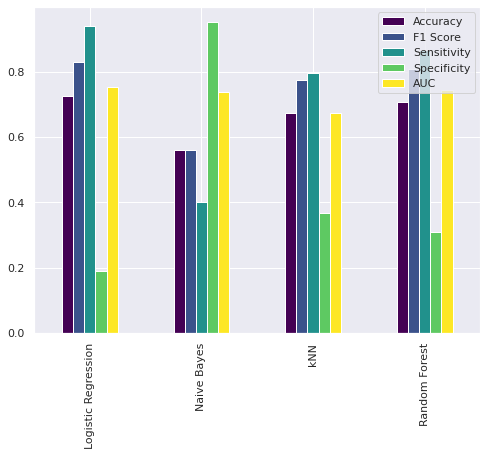

In [27]:
sns.set_theme()
metrics.plot.bar(figsize=(8,6), colormap = 'viridis')
plt.xticks(ticks=[0, 1,2,3], labels=metrics['Classifier'])
plt.show()

LogisticRegression(random_state=1)


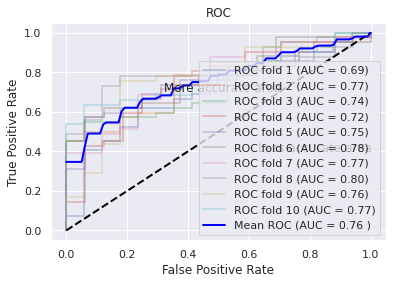

GaussianNB()


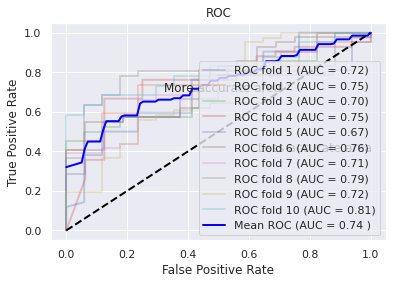

KNeighborsClassifier()


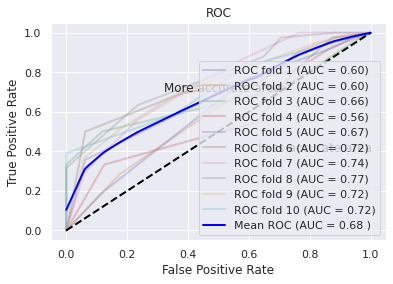

RandomForestClassifier(max_depth=10, min_samples_split=5)


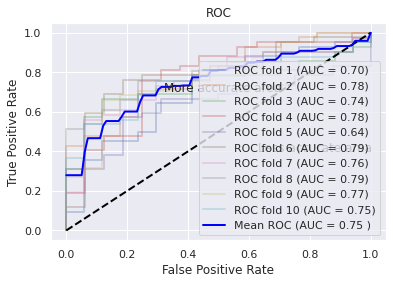

In [28]:
# --------> code from: https://www.kaggle.com/kanncaa1/roc-curve-with-k-fold-cv
i = 0
for clf in classifiers:
    print(clf)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    for train_index, test_index in cv.split(X_scaled, y.ravel()):
        prediction = clf.fit(X_scaled[train_index],y.ravel()[train_index]).predict_proba(X_scaled[test_index])
        fpr, tpr, t = roc_curve(y.ravel()[test_index], prediction[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i= i+1
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.text(0.32,0.7,'More accurate area',fontsize = 12)
    plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
    plt.show()